In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam


import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage import color
from skimage import io
from skimage.transform import resize
import time
from IPython import display

In [0]:
def vgg_global_style(layer_name):
  vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
  vgg.load_weights('/content/drive/My Drive/Dataset/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
  vgg.trainable = False
  outputs = vgg.get_layer(layer_name).output
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [3]:
vgg_model = vgg_global_style('fc1')
print(vgg_model.output_shape)
###### FEED FORWARD TEST ###########
# real_image = np.array(PIL.Image.open("/content/danbooru_2897927_a39fedcea885102ef9781a78d9a9bc45.jpg").resize((224,224)), dtype=float)
# real_image = np.array([real_image])
# output_test = vgg_model(real_image)
# output_test = np.array([output_test])
# print(output_test.shape)

(None, 4096)


In [0]:
def generator(pretrained_weights=None, input_size=(256,256,1), vgg_style_size=(1, 1, 4096)):
  inputs = Input(input_size, name='main_input')
  global_style_hint = Input(vgg_style_size, name='style_input')
  global_style_hint_dense = Dense(2048, kernel_initializer='he_normal', name='dense_style')(global_style_hint)
  # global_dense_activ = LeakyReLU()(global_style_hint_dense)
  # style_normalise_reshape = Reshape((1, 1, 2048))(global_style_hint_dense)
  # print(global_style_hint_cover.shape)

  ###### U-net Encoder ######
  conv1 = Conv2D(16, 1, padding='same', kernel_initializer='he_normal', name='conv1')(inputs)
  activ1 = LeakyReLU()(conv1)
  conv1 = Conv2D(16, 1, padding='same', kernel_initializer='he_normal', name='conv1_1')(activ1)
  activ1 = LeakyReLU()(conv1)
  pool1 = AveragePooling2D(pool_size=(2,2), strides=2, name='pool1')(activ1)

  conv2 = Conv2D(32, 1, padding='same', kernel_initializer='he_normal', name='conv2')(pool1)
  activ2 = LeakyReLU()(conv2)
  conv2 = Conv2D(32, 1, padding='same', kernel_initializer='he_normal', name='conv2_1')(activ2)
  activ2 = LeakyReLU()(conv2)
  pool2 = AveragePooling2D(pool_size=(2,2), strides=2, name='pool2')(activ2)

  conv3 = Conv2D(64, 1, padding='same', kernel_initializer='he_normal', name='conv3')(pool2)
  activ3 = LeakyReLU()(conv3)
  conv3 = Conv2D(64, 1, activation='relu', padding='same', kernel_initializer='he_normal', name='conv3_1')(activ3)
  activ3 = LeakyReLU()(conv3)
  pool3 = AveragePooling2D(pool_size=(2,2), strides=2, name='pool3')(activ3)

  conv4 = Conv2D(128, 1, padding='same', kernel_initializer='he_normal', name='conv4')(pool3)
  activ4 = LeakyReLU()(conv4)
  conv4 = Conv2D(128, 1, padding='same', kernel_initializer='he_normal', name='conv4_1')(activ4)
  activ4 = LeakyReLU()(conv4)
  pool4 = AveragePooling2D(pool_size=(2,2), strides=2, name='pool4')(activ4)

  conv5 = Conv2D(256, 1, padding='same', kernel_initializer='he_normal', name='conv5')(pool4)
  activ5 = LeakyReLU()(conv5)
  conv5 = Conv2D(256, 1, padding='same', kernel_initializer='he_normal', name='conv5_1')(activ5)
  activ5 = LeakyReLU()(conv5)
  pool5 = AveragePooling2D(pool_size=(2,2), strides=2, name='pool5')(activ5)

  ###### VGG Concat ######
  conv_style = Conv2D(2048, 1, padding='same', kernel_initializer='he_normal', name='conv_style')(pool5)
  normalise = BatchNormalization()(conv_style)
  # print(conv6.shape)
  # activ_style = LeakyReLU()(normalise)
  style_hint = tf.keras.layers.Add()([conv_style, global_style_hint_dense])
  activ_style_1 = LeakyReLU()(style_hint)
  # style_hint = tf.math.add(conv_style, global_style_hint_dense_reshape)
  # style_hint = conv_style.add(global_style_hint_dense_reshape)
  # merge_style = 

  ###### decoder1 ########
  decoder1_1 = Conv2D(512, 1, padding='same', kernel_initializer='he_normal')(activ5)
  activ_decoder1_1 = LeakyReLU()(decoder1_1)
  decoder1_2 = Conv2D(256, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder1_1)))
  activ_decoder1_2 = LeakyReLU()(decoder1_2)
  decoder1_3 = Conv2D(128, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder1_2)))
  activ_decoder1_3 = LeakyReLU()(decoder1_3)
  decoder1_4 = Conv2D(64, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder1_3)))
  activ_decoder1_4 = LeakyReLU()(decoder1_4)
  decoder1_5 = Conv2D(32, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder1_4)))
  activ_decoder1_6 = LeakyReLU()(decoder1_5)

  decoder1_output = Conv2D(1, 1, activation='linear')(activ_decoder1_6)



  ##### U-net decoder ######
  conv6 = Conv2D(512, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_style_1)))
  activ6_1= LeakyReLU()(conv6)
  conv6 = Conv2D(512, 1, padding='same', kernel_initializer='he_normal')(activ6_1)
  activ6= LeakyReLU()(conv6)
  merge6 = tf.keras.layers.concatenate([conv5, activ6], axis=3)

  conv7 = Conv2D(128, 1, padding='same', kernel_initializer='he_normal', name='Unet_decoder1')((UpSampling2D(size=(2,2))(merge6)))
  activ7= LeakyReLU()(conv7)
  conv7 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(activ7)
  activ7= LeakyReLU()(conv7)
  merge7 = tf.keras.layers.concatenate([pool3, activ7], axis=3)

  conv8 = Conv2D(64, 1, activation='relu', padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(merge7)))
  activ8= LeakyReLU()(conv8)
  conv8 = Conv2D(64, 1, activation='relu', padding='same', kernel_initializer='he_normal')(activ8)
  activ8= LeakyReLU()(conv8)
  merge8 = tf.keras.layers.concatenate([pool2, activ8], axis=3)

  conv9 = Conv2D(32, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(merge8)))
  activ9= LeakyReLU()(conv9)
  conv9 = Conv2D(32, 1, padding='same', kernel_initializer='he_normal')(conv9)
  activ9= LeakyReLU()(conv9)
  merge9 = tf.keras.layers.concatenate([pool1, activ9], axis=3)

  conv10 = Conv2D(16, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(merge9)))
  activ10= LeakyReLU()(conv10)
  conv10 = Conv2D(16, 1, padding='same', kernel_initializer='he_normal')(activ10)
  activ10= LeakyReLU()(conv10)
  final_output = Conv2D(3, 1, activation='linear')(activ10)


  ###### decoder2 #####
  decoder2_1 = Conv2D(512, 1, padding='same', kernel_initializer='he_normal')(activ6_1)
  activ_decoder2_1 = LeakyReLU()(decoder2_1)
  decoder2_2 = Conv2D(256, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder2_1)))
  activ_decoder2_2 = LeakyReLU()(decoder2_2)
  decoder2_3 = Conv2D(128, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder2_2)))
  activ_decoder2_3 = LeakyReLU()(decoder2_3)
  decoder2_4 = Conv2D(64, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder2_3)))
  activ_decoder2_4 = LeakyReLU()(decoder2_4)
  decoder2_5 = Conv2D(32, 1, padding='same', kernel_initializer='he_normal')((UpSampling2D(size=(2,2))(activ_decoder2_4)))
  activ_decoder2_5 = LeakyReLU()(decoder2_5)

  decoder2_output = Conv2D(3, 1, activation='linear')(activ_decoder2_5)


  model = Model([inputs,global_style_hint], [decoder1_output,decoder2_output, final_output])


  if (pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

In [0]:
generator_model = generator()
# ############ TESTING FEED FORWARD CELL ###################
# print(output_test.shape)
# output_test = np.reshape(output_test, (1, 1, 1, 4096))
# image = PIL.Image.open('/content/test.jpg')
# image = image.resize((256,256))
# noise = np.array(image)
# noise = np.reshape(noise, (1, 256, 256, 1))
# noise = (noise - 127.5) / 127.5

# for layers in generator_model.output:
#   print(layers.name,"%%%%", type(layers))



# # noise = np.array([noise])
# generated_image = generator_model([noise, output_test])
# decoder1 = generated_image[0]
# decoder2 = generated_image[1]
# final_output = generated_image[2]
# print(final_output.shape)
# # plt.imshow(noise[0, :, :, 0], cmap='gray')
# # plt.imshow(decoder2[0, :, :, :])
# # plt.imshow(final_output[0, :, :, :])
# # plt.imshow(decoder1[0, :, :, 0],cmap='gray')

In [8]:
######## MODEL GRAPH ############
tf.keras.utils.plot_model(
    generator_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

print(generator_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 16) 32          main_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 16) 272         leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [0]:
def discriminator(vgg_style=(1, 1, 4096)):
  inputs = Input(vgg_style)
  output_dense = Dense(2048, name='dense_style')(inputs)
  style_output = Dense(2048, name='style_output')(output_dense)
  content_output = Dense(1, name='content_output')(output_dense)
  model = Model(inputs, [style_output, content_output])

  return model


In [10]:
discriminator_model = discriminator()
# generator_model.compile(optimizer='rmsprop',
#               loss={'final_output': 'binary_crossentropy', 'decoder1_output': 'mean_squared_error', 'decoder2_output': 'mean_squared_error'},
#               loss_weights={'final_output': 1., 'decoder1_output': 0.3, 'decoder2_output': 0.9})
print(discriminator_model.input_shape)

(None, 1, 1, 4096)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output, real_style, fake_style):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    style_loss = tf.keras.losses.mean_squared_error(real_style , fake_style)
    total_loss = tf.math.add(real_loss ,fake_loss, style_loss)
    return total_loss

In [0]:
def generator_loss(fake_output, decoder1_output, black_and_white, decoder2_output, real_image, output_gen):
  alpha = 0.3
  beta = 0.9
  decoder1_loss = tf.keras.losses.mean_squared_error(decoder1_output, black_and_white)
  decoder2_loss = tf.keras.losses.mean_squared_error(decoder2_output, real_image)
  MainLoss = tf.keras.losses.mean_squared_error(output_gen, real_image)
  Output_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  # print(decoder1_loss ,decoder2_loss ,Output_loss)
  # print(decoder1_loss.shape ,decoder2_loss.shape ,Output_loss.shape)
  image_loss = tf.math.add(0.3*decoder1_loss, 0.9*decoder2_loss, MainLoss)
  Total_Loss = tf.math.add(image_loss, Output_loss)
  return Total_Loss

In [0]:
####### TESTING LOSS WITH SAMPLE INPUT ###########

# black_and_white = io.imread('/content/danbooru_2897927_a39fedcea885102ef9781a78d9a9bc45.jpg', as_gray=True)
# black_and_white = np.array(resize(black_and_white, (256, 256)), dtype=float)
# decoder1_output = PIL.Image.open("/content/test.jpg")
# decoder1_output = np.array(decoder1_output.resize((256,256)), dtype=float)
# decoder2_output = np.random.randn(256, 256, 3)
# real_image = np.array(PIL.Image.open("/content/danbooru_2897927_a39fedcea885102ef9781a78d9a9bc45.jpg").resize((256,256)), dtype=float)

# print(black_and_white.shape)
# print(decoder1_output.shape)
# print(decoder2_output.shape)
# print(real_image.shape)
# fake_output = np.random.randn(256, 256, 3)
# print(fake_output.shape)
# loss = generator_loss(fake_output, decoder1_output, black_and_white, decoder2_output, real_image)
# print(loss.shape)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

In [0]:
EPOCHS = 70
noise_dim = 100
num_examples_to_generate = 1
# output_test = np.random.randn(1, 1, 4096)

In [0]:
def train_step(batch_bw, batch_edge, batch_colour, resized_colour):
  noise = batch_edge
  # print(noise.shape)
  black_and_white = batch_bw
  # black_and_white = tf.cast(black_and_white, tf.float32)
  # print(black_and_white.shape)
  final_image = batch_colour
  # final_image = tf.cast(final_image, tf.float32)
  # print(final_image.shape)
  # print("SOSOSOS")

  # input_style = vgg_model(resized_colour)
  
  input_style = resized_colour
  input_style = tf.reshape(input_style, [8, 1, 1, 4096])

  
  # input_style = np.array(input_style)
  # print(input_style.shape)



  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    decoder1_output, decoder2_output, final_output = generator_model([noise, input_style], training=True)
    
    generated_images_resize = tf.image.resize(final_output, (224, 224))
    generated_images_style = vgg_model(generated_images_resize)
    generated_images_style = tf.reshape(generated_images_style, [8, 1, 1, 4096])

    # print("gen")

    real_output_style, real_output_content = discriminator_model(input_style, training=True)
    fake_output_style, fake_output_content = discriminator_model(generated_images_style, training=True)

    # print("disc")

    decoder1_output = tf.cast(decoder1_output, tf.float32)
    decoder2_output = tf.cast(decoder2_output, tf.float32)
    final_image = tf.cast(final_image, tf.float32)

    
    gen_loss = generator_loss(fake_output_content, decoder1_output, black_and_white, decoder2_output, final_image, final_output)
    disc_loss = discriminator_loss(real_output_content, fake_output_content, real_output_style, fake_output_style)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)




  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [0]:
def train(batch_bw, batch_edge, batch_colour, resized_colour, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in zip(batch_bw, batch_edge, batch_colour, resized_colour):
      train_step(image_batch[0], image_batch[1], image_batch[2], vgg_model(image_batch[3]))

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                             epoch + 1,
                             [image_batch[1], tf.reshape(vgg_model(image_batch[3]), [8, 1, 1, 4096])])

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model,
                           epochs,
                           [image_batch[1], tf.reshape(vgg_model(image_batch[3]), [8, 1, 1, 4096])])

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions[2].shape[0]):
      plt.subplot(4, 4, i+1)
      display_image = cv2.cvtColor(np.array(predictions[2][i, :, :, :]), cv2.COLOR_BGR2RGB)
      plt.imshow(display_image.astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
# black_and_white = np.load('/content/drive/My Drive/Dataset/bandw_dataset_anime.npy')
# edges = np.load('/content/drive/My Drive/Dataset/edge_dataset_anime.npy')
colour = np.load('/content/drive/My Drive/Dataset/colour_dataset_anime.npy')[:1920]

In [51]:
resized_colour = []
for element in colour:
  image = cv2.resize(element, (224, 224))
  image = np.array(image)
  resized_colour.append(image)

resized_colour = np.array(resized_colour)
print(resized_colour.shape)

black_and_white = np.load('/content/drive/My Drive/Dataset/bandw_dataset_anime.npy')[:1920].reshape(1920, 256, 256, 1).astype('float32')
black_and_white = black_and_white

edges = np.load('/content/drive/My Drive/Dataset/edge_dataset_anime.npy')[:1920].reshape(1920, 256, 256, 1).astype('float32')
edges = (edges - 127.5) / 127.5

colour = colour.reshape(1920, 256, 256, 3).astype('float32')

resized_colour = resized_colour.reshape(1920, 224, 224, 3).astype('float32')
resized_colour = (resized_colour)

BUFFER_SIZE = 1920
BATCH_SIZE = 8
batch_bw = tf.data.Dataset.from_tensor_slices(black_and_white).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
batch_edge = tf.data.Dataset.from_tensor_slices(edges).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
batch_colour = tf.data.Dataset.from_tensor_slices(colour).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
resized_colour = tf.data.Dataset.from_tensor_slices(resized_colour).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(batch_bw)
print(batch_edge)
print(batch_colour)
print(resized_colour)


(1920, 224, 224, 3)
<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>
<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>
<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>


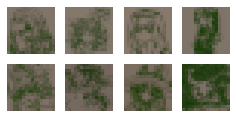

Time for epoch 2 is 87.89272403717041 sec


In [0]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
train(batch_bw, batch_edge, batch_colour, resized_colour, EPOCHS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1, 4096)


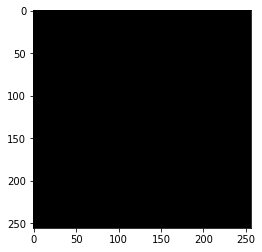

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
outline = cv2.imread('/content/test.jpg')
outline = cv2.cvtColor(outline, cv2.COLOR_BGR2GRAY)
outline = cv2.resize(outline, (256, 256))
outline = np.array([outline])
outline = outline.reshape(1, 256, 256, 1).astype('float32')
outline = (outline - 127.5) / 127.5

style = cv2.imread('/content/danbooru_2897927_a39fedcea885102ef9781a78d9a9bc45.jpg')
style = cv2.resize(style, (224, 224))
style = np.array(style)
style = style.reshape(1, 224, 224, 3).astype('float32')
style = (style - 127.5) / 127.5
style = vgg_model(style)
style = np.array([style])

print(style.shape)
prediction = generator_model([outline, style])

plt.imshow(prediction[2][0, :, :, :])

In [0]:
plt.imshow(black_and_white[1, :, :, 0],  cmap='gray')

In [0]:
plt.imshow(edges[1, :, :, 0],  cmap='gray')

In [0]:
rgb = cv2.cvtColor(colour[1, :, :, :], cv2.COLOR_RGB2BGR)
plt.imshow(rgb)

In [0]:
plt.imshow(resized_colour[0, :, :, :])

In [39]:
for image_batch in zip(batch_bw, batch_edge, batch_colour, resized_colour):
    pass


# plt.imshow(image_batch[0][0, :, :, 0], cmap='gray')
# plt.imshow(image_batch[1][0, :, :, 0], cmap='gray')
plt.imshow(np.array(image_batch[2][0, :, :, :]))
# plt.imshow(np.array(image_batch[3][0, :, :, :]))

InvalidArgumentError: ignored